Local Devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15000846141296553024
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3121463717337573242
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]
4423680/4422102 [==============================] - 0s 0us/step
Iteration 0: Training Loss = 2.3244133819816377 Training Accuracy = 0.8999983072280884
Iteration 1: Training Loss = 2.2237532755887464 Training Accuracy = 0.8999999761581421
Iteration 2: Training Loss = 2.1428759197532585 Training Accuracy = 0.8999999761581421
Iteration 3: Training Loss = 2.0628233387295873 Training Accuracy = 0.8999999761581421
Iteration 4: Training Loss = 1.98051967469396 Training Accuracy = 0.9000633358955383
Iteration 5: Training Loss = 1.8956188470260793 Training Accuracy = 0.900303304195404
Iteration 6: Training Loss = 1.8063274428764

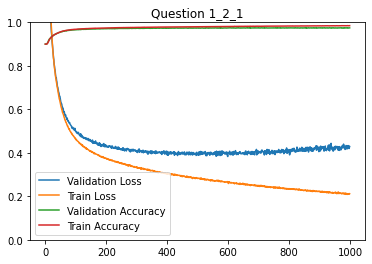

Execution Time:  433.294130735


In [1]:
# -*- coding: utf-8 -*-
"""
Name: Shane Quinn
Student Number: R00144107
Email: shane.quinn1@mycit.ie
Course: MSc Artificial Intelligence
Module: Deep Learning
Date: 03/04/2021
"""

import tensorflow as tf
from keras.utils import np_utils
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import functools
import time
import numpy as np


def forward_pass(X, w1, w2, w3, b1, b2, b3, dop=0.1):
    """
    Push feature data through neural network. Returns 10 class probabilities for all feature instances

    Parameters
    ----------
    X : tf.Variable
        Pre-processed input data.
    w1 : tf.Variable
        Layer 1 learnable weights.
    w2 : tf.Variable
        Layer 2 learnable weights.
    w3 : tf.Variable
        Layer 3 learnable weights.
    b1 : tf.Variable
        Layer 1 bias.
    b2 : tf.Variable
        Layer 2 bias.
    b3 : tf.Variable
        Layer 3 bias.
    dop : Float32, optional
        Drop out probability, probability of each neuron to be dropped. The default is 0.1.

    Returns
    -------
    H : tf.Variable
        Softmax layer output predicted probability of each class.
    """
  
    #Layer 1- 300 Relu Neruons
    A = tf.matmul(w1, tf.transpose(X)) + b1                     #A1 = w1.X + b1
    H = tf.keras.activations.relu(A)                            #H1 = act(A1)
    #Layer 2 - Dropout Layer
    datatype = w1.dtype                                         #Get datatype used (float32/64)
    probThres = 1-dop                                           #Threshold of neurons to be dropped
    #Create matrix of shape H with boolean 1s in probThresh locations, and 0s in dop locations
    dropMat = np.random.rand(H.shape[0], H.shape[1]) < probThres 
    #Cast to tf variable for interacting with H
    dropMat = tf.cast(dropMat, datatype)
    #Elementwise multiply mask matrix by H, 'dropping' neurons
    dropResult = tf.math.multiply(H, dropMat)  
    #Scale up values in H to compensate for dropped values
    H = tf.math.divide(dropResult, probThres)    
    #Layer 3 - 100 Relu Neurons
    A = tf.matmul(w2, H) + b2                                   #A2 = w2.H1 + b2
    H = tf.keras.activations.relu(A)                            #H2 = act(A2)
    #Layer 4 - Softmax = (e^A)/sum(A)
    A = tf.matmul(w3, H)+b3                                     #A3 = w3.H2 + b3
    H = tf.exp(A) / tf.reduce_sum(tf.exp(A), axis=0)            #H3 = act(A3)
    
    return H
    

def cross_entropy(pred_y, y):
    """
    Take in softmax probabilities (output of forward_pass) and true class labels and calculate cross entropy loss

    Parameters
    ----------
    pred_y : tf.Variable
        Predictions (Output of softmax layer in forward_pass()).
    y : tf.Variable
        One-hot encoded true class labels.

    Returns
    -------
    cross_ent : Cross entropy loss
        tf.Variable.
    """
        
    #Cross entropy loss per class = -sum((True class encoded values)*log(predicted probabilities))
    a = -tf.reduce_sum(y * tf.math.log(pred_y), axis=0)
    #Cross entropy loss = mean of all losses calculated above.
    cross_ent = tf.reduce_mean(a, axis=0)

    return cross_ent


def calculate_accuracy(pred_y, y):
    """
    Calculate the model accuracy given predicted probabilities and true class labels

    Parameters
    ----------
    pred_y : tf.Variable
        Predicted class probabilities, output of forward pass/softmax layer.
    y : tf.Variable
        True class values.
    datatype : tf.float32/tf.float64, optional
        One of the above tf datatypes. The default is tf.float32.

    Returns
    -------
    accuracy : float32
        Model Accuracy.
    """

    # Convert predicted probabilities to 0 or 1
    pred_y = tf.round(pred_y)
    # Boolean True (1) if prediction is correct
    predictions = tf.cast(tf.equal(pred_y, y), tf.float32)
    #Mean value of correct predictions
    accuracy = tf.reduce_mean(predictions)
    
    return accuracy


def exec_time(func):
    """
    Generic Execution time recorder, pass in function. Records execution time using decorators

    Parameters
    ----------
    func : FUNCTION
        Function .
    """
  
    @functools.wraps(func)
    def record_exec_time(*args, **kwargs):
        start_time = time.perf_counter()
        mn = func(*args, **kwargs)
        execution_time = time.perf_counter() - start_time
        print("Execution Time: ", execution_time)
        return mn

    return record_exec_time

@exec_time 
def main():
      
    X, y, X_val, y_val = pre_process() 

    #Initialise Learning rate and iterations.
    learning_rate = 0.05
    iterations = 1000
    datatype = tf.float64
    dop = 0.75              #Drop out probability
    
    #Initialise lists for saving accuracies/loss
    te_acc = []
    tr_acc = []
    te_loss = []
    tr_loss = []
    
    # Create tf variables from data
    X = tf.cast(X, datatype)
    y = tf.cast(y, datatype)
    X_val = tf.cast(X_val, datatype)
    y_val = tf.cast(y_val, datatype)
    
    #Initialise Adam Optimizer
    adam = tf.keras.optimizers.Adam()
    
    #Initialise weights and bias
    zeros = tf.zeros_initializer()
    layer1_weights = tf.Variable(tf.random.normal([300,784], stddev=0.05, dtype=datatype))
    layer2_weights = tf.Variable(tf.random.normal([100, 300], stddev=0.05, dtype=datatype))
    layer3_weights = tf.Variable(tf.random.normal([10, 100], stddev=0.05, dtype=datatype))
    layer1_bias = tf.Variable(0, dtype=datatype)
    layer2_bias = tf.Variable(0, dtype=datatype)
    layer3_bias = tf.Variable(0, dtype=datatype)
    
    #Repeat gradient descent loop 'iterations' times
    for i in range(iterations):
        
        with tf.GradientTape() as tape:
            #Create instance of gradient tape to record forward pass and calculate gradients for learnable weights and biases
            pred_y = forward_pass(X, layer1_weights, layer2_weights, layer3_weights, layer1_bias, layer2_bias, layer3_bias, dop)
            loss = cross_entropy(pred_y, y)
            
        tr_loss.append(loss)
        #Calculate Gradients using gradient tape
        gradients = tape.gradient(loss, [layer1_weights, layer2_weights, layer3_weights, layer1_bias, layer2_bias, layer3_bias])
        accuracy = calculate_accuracy(pred_y, y)
        tr_acc.append(accuracy)
        print("Iteration {}: Training Loss = {} Training Accuracy = {}".format(i, loss.numpy(), accuracy.numpy()))
        
        #Apply gradients using adaptive movement estimation, see accompanied report for more details
        adam.apply_gradients(zip(gradients, [layer1_weights, layer2_weights, layer3_weights, layer1_bias, layer2_bias, layer3_bias]))
        
        #Test model on validation data
        test_pred_y = forward_pass(X_val, layer1_weights, layer2_weights, layer3_weights, layer1_bias, layer2_bias, layer3_bias, dop)
        test_loss = cross_entropy(test_pred_y, y_val)
        te_loss.append(test_loss)
        te_acc.append(calculate_accuracy(test_pred_y, y_val))
    
    print("Dropout Probability: ", dop)
    plt.title("Question 1_2_1")
    plt.plot(te_loss, label="Validation Loss")
    plt.plot(tr_loss, label="Train Loss")
    plt.plot(te_acc, label="Validation Accuracy")
    plt.plot(tr_acc, label="Train Accuracy")
    plt.ylim((0,1))
    plt.legend()
    plt.show()
    

def pre_process():
    """
    Supplied Code for pre-processing Fashion MNIST dataset. Returns target class values and training data for training and validation

    Returns
    -------
    tr_x : NUMPY N-D ARRAY
        X Training Data.
    tr_y : NUMPY N-D ARRAY
        y target class values 1 hot encoded (training data).
    te_x : NUMPY N-D ARRAY
        X Test Data.
    te_y : NUMPY N-D ARRAY
        y test target class values 1 hot encoded (test data).

    """
    
    fashion_mnist = tf.keras.datasets.fashion_mnist 
    (tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()
    tr_x = tr_x.reshape(tr_x.shape[0], 784)
    te_x = te_x.reshape(te_x.shape[0], 784)
    tr_x = tr_x / 255.0
    te_x = te_x / 255.0
    tr_y = np_utils.to_categorical(tr_y,10)
    tr_y = tr_y.T
    te_y = np_utils.to_categorical(te_y,10)
    te_y = te_y.T

    return tr_x, tr_y, te_x, te_y


if __name__ == '__main__':
    print("Local Devices: \n", device_lib.list_local_devices())
    main()